<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%206/Assignment%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #06

Xuanang Zhu

Description: Fit California House prices into Random Forest and produce PDP, ICE, and ALE plots

https://github.com/xazhu9/AIPI-590/blob/main/Assignment%206/Assignment%206.ipynb


In [ ]:
pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-f6luctrs/alepython_7dd575cc62584cfdb7055d0e31e9c18f
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-f6luctrs/alepython_7dd575cc62584cfdb7055d0e31e9c18f
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot

Processing data

In [ ]:
# Load data set of california housing price
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['MedHouseVal'] = housing.target  # Set MedHouseVal as target

EDA

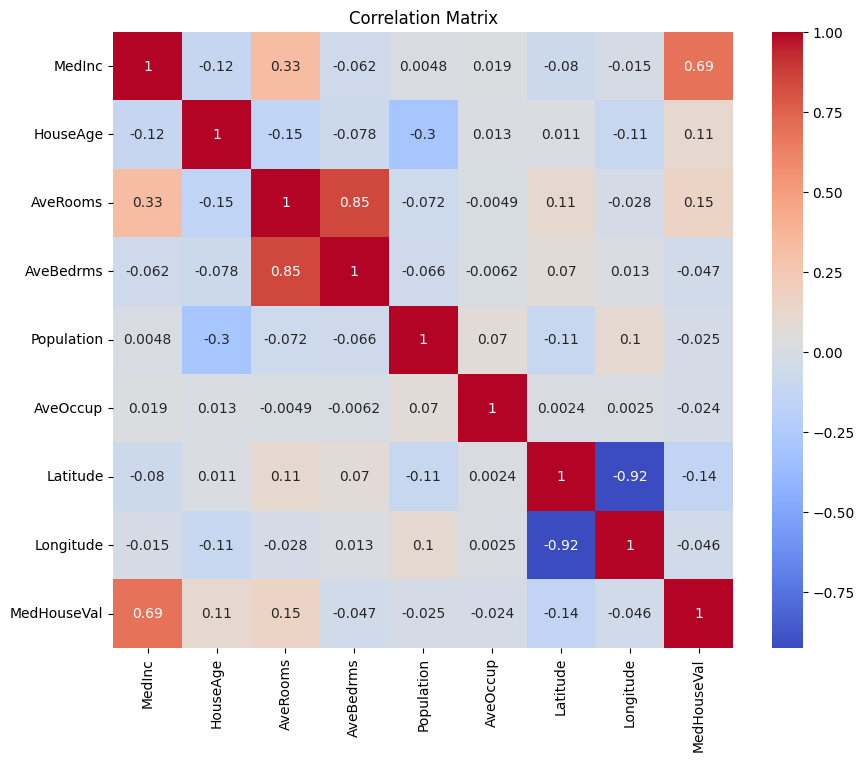

In [ ]:
# Correlation analysis
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Random Forest model training

In [ ]:
# split data to train and test set
X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Using MedInc for plot

PDP Plot

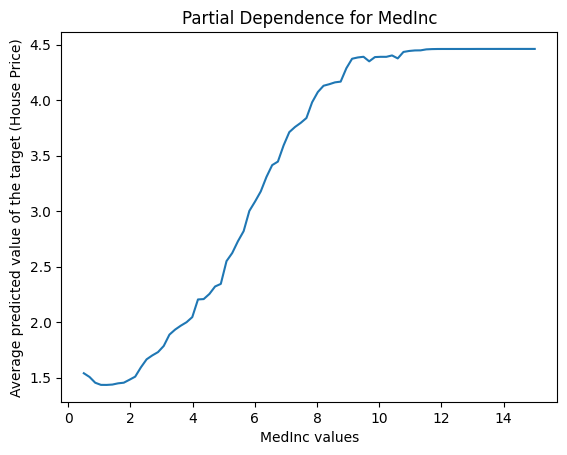

In [ ]:
# Get the feature name
feature_index = 0  # Select MedInc
feature_name = X.columns[feature_index]  # Get the feature name, which should be 'MedInc'

# Generate a grid of feature values (from the minimum to maximum value of the feature, generating 80 values)
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize an array to store the average prediction for each feature value
average_predictions = np.zeros_like(feature_values)

# Create a copy of the dataset to modify feature values
X_modified = X.copy()

# Iterate through the grid of feature values
for i, value in enumerate(feature_values):
    # Replace all values of the selected feature with the current value in the grid
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset (assuming this is a regression model)
    predictions = model.predict(X_modified)

    # Calculate the average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence plot (PDP) for the selected feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'{feature_name} values')  # Use the feature name as the label for the X-axis
plt.ylabel('Average predicted value of the target (House Price)')
plt.title(f'Partial Dependence for {feature_name}')  # Use the feature name as the plot title
plt.show()



The plot shows significant positive correlation between MedInc, that in general, as MedInc increases, Predicted House value increases as well.

An interesting point would be that different interval shows different increases in house value. This implies that as MedInc values reaches 8, it will have less influence on House Value.

ICE plot

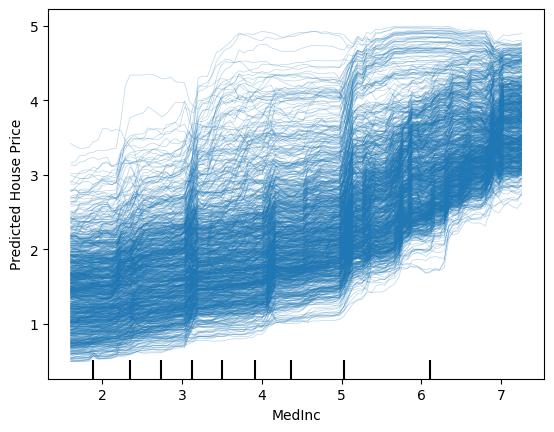

In [ ]:
# Use MedInc as feature
features = ["MedInc"]

# Generate ICE plot
display = PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')

# change Y lable to "Predicted House Price"
display.axes_[0, 0].set_ylabel("Predicted House Price")

# show the plot
plt.show()


The ICE graph shows how the predicted price for each data point change with the MedInc. In general, the predicted house price increase as the MedInc increases. Different data points shows different sensitivity to the change of MedInc, and although in general, the price and MedInc are positivly correlated, there are several downwards in price as MedInc increase.

An interesting point would be that certain sample prediction curves exhibit sharp increases in specific income ranges. This is likely due to the interaction effect between MedInc (median income) and other features (such as house age or number of rooms) that are correlated. Even though only MedInc is being changed in the ICE plot, the model's predictions implicitly take these other correlated features into account, causing the model to sharply adjust its predictions for house prices in certain income ranges. This phenomenon reflects the model’s complex interaction between multiple features, rather than relying solely on one feature.

On the other hand, such pattern is similar to the PDP, so the dramatic increase could due to that under specific setting, the price is more sensitive to the MedInc at certain period.

ALE plots

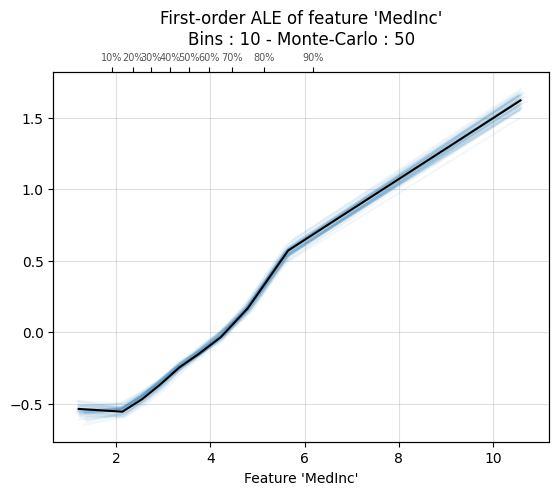

<Axes: title={'center': "First-order ALE of feature 'MedInc'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'MedInc'">

In [ ]:
ale_plot(model, X_train, 'MedInc', monte_carlo=True)

This ALE plot shows the local accumulated effect of median income (MedInc) on house price predictions. As MedInc increases, the ALE values gradually shift from negative to positive, indicating that higher median income leads to higher predicted house prices. In the mid-income range (approximately between MedInc values of 4 and 7), the change in house price predictions is the most significant, with a steeper slope, showing that MedInc has the strongest impact in this range. At higher income levels (above MedInc of 7), the curve flattens, indicating a diminishing marginal effect, where further increases in income have a smaller impact on predicted house prices.

Differences comparing to PDP:

In PDP, the interval when MedInc increasing lead to house value decrease is about 0-0.5, but on ALE, such interval is about 0-4. In addition, the plot for PDP gets signifanct flatter when MedInc reach around 9, while ALE shows no such huge changes. The ALE also shows how the data distributed, while PDP is a general image.

ALE focuses more on the local effects of the feature (in this case, MedInc), and it accounts for feature correlations, reflecting the impact of MedInc based on the actual data distribution. In contrast, PDP shows the global average effect of MedInc on house prices, assuming other features remain constant, which can sometimes obscure local variations. In summary, ALE captures how MedInc affects house prices across different income ranges by accumulating local effects, while PDP smooths out these details and presents the broader average trend. This could be why the PDP and ALE results differ, especially in the low and high-income ranges.

Discussion about correlation and influence on result:


Based on the correlation matrix, MedInc (median income) has a strong positive correlation (0.69) with MedHouseVal (house value), indicating that higher median income leads to higher predicted house prices, which aligns with the trends observed in the plots. Additionally, while MedInc shows moderate correlations with features like AveRooms (0.33), it is mostly independent of other features like HouseAge and Population, which suggests that MedInc plays a distinct role in predicting house prices. The strong correlation between AveRooms and AveBedrms (0.85) may cause multicollinearity issues in the model, potentially leading to overlapping influence. In this case, focusing on MedInc as the primary feature for analysis helps avoid such issues and provides a clearer view of how income affects house prices. But still, MedInc's correlation with the AveRooms can still cause bias to the result of the graph, especially for PDP